In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re
import json
import pandas as pd
from tqdm import tqdm


def load_data(results_dir: str):
    prec_at_k = pd.DataFrame(columns=["In-Layer", "Out-Layer", "Training Target", "N", "K", "Precision@1", "Method", "Context Index"])
    surprisal = pd.DataFrame(columns=["In-Layer", "Out-Layer", "Training Target", "N", "Surprisal", "Method", "Context Index"])

    for folder in tqdm(os.listdir(results_dir)):
        if ".DS_Store" in folder:
            continue
        in_layer, out_layer, training_tar, metric, method = re.findall(r"layer(\d+)to(\d+)_tk([\d])_([a-z\d\@]*)_([a-z\d]*)", folder)[0]
        result = json.load(open(os.path.join(results_dir, folder, "test_results.json"), "r"))
        context_idx = method[-1] if method.startswith("ctx") else None
        training_tar = training_tar if not method.startswith("ctx") else -1
        method = "Learned prompt" if method == "prefix" else "Fixed prompt"

        if metric == "surprisal":
            for n in range(len(result["surprisal"])):
                surprisal.loc[len(surprisal.index)] = [int(in_layer) + 1, int(out_layer), int(training_tar), int(n), float(result["surprisal"][n]), method, context_idx]
        else:
            for n in result.keys():
                for k in range(len(result[n])):
                    prec_at_k.loc[len(prec_at_k.index)] = [int(in_layer) + 1, int(out_layer), int(training_tar), int(n), k+1, float(result[n][k]), method, context_idx]
    
    return prec_at_k, surprisal

In [4]:
prec_df, surp_df = load_data("results/testing/")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 449/449 [00:09<00:00, 47.51it/s]


#### Adding linear results to the DataFrames

In [5]:
linear_baseline = pd.read_csv("./results/linear-baseline-version-results.csv")
for i in linear_baseline.index:
    name = linear_baseline.loc[i, "Name"]
    in_layer, n = re.match(r"PREV_L([-?\d]+)_OUT_L27_NEXT_T(-?\d+)", name).groups()
    n = int(n) + 1
    in_layer = int(in_layer) + 1
    if in_layer == 0:
        continue
    results = float(linear_baseline.loc[i]["test/accuracy"]) / 100
    prec_df.loc[len(prec_df.index)] = [in_layer, 27, -1, n, 1, results, "Linear Vocab", None]

linear_model = pd.read_csv("./results/final-conll-linear-run.csv")
for i in linear_model.index:
    name = linear_model.loc[i, "Name"]
    in_layer, n = re.match(r"PREV_L([-?\d]+)_OUT_L27_NEXT_T(-?\d+)", name).groups()
    if in_layer == str(-1):
        continue
    n = int(n) + 1
    in_layer = int(in_layer) + 1
    results = float(linear_model.loc[i]["test/accuracy"]) / 100
    prec_df.loc[len(prec_df.index)] = [in_layer, 27, -1, n, 1, results, "Linear Model", None]

linear_surp_df = pd.read_csv("./results/linear_surprisal.csv")
surp_df = pd.concat([surp_df, linear_surp_df], ignore_index=True)

for i in range(28):
    prec_df.loc[len(prec_df.index)] = [i+1, 27, -1, 1, 1, 0.201, "Pile Bi-gram", None]
    prec_df.loc[len(prec_df.index)] = [i+1, 27, -1, 3, 1, 2000, "Pile Bi-gram", None]

#### Functions

In [100]:
def plot_by_training_objective(df: pd.DataFrame, ax, train_target, n, with_legend=True):
    sns.set(style="whitegrid", font_scale=3.5)
    new_df = df[(df["K"] == 1)]
    new_df = new_df[(new_df["Training Target"] == train_target) | (new_df["Training Target"] == -1)]
    new_df = new_df[new_df["N"] == n]
    plot = sns.lineplot(
        data=new_df, 
        x="In-Layer", 
        y="Precision@1", 
        hue="Method", 
        hue_order=["Learned prompt", "Fixed prompt", "Linear Model", "Linear Vocab", "Pile Bi-gram"],
        style="Method", 
        dashes=False,
        markers=["o", ">", "P", "s", ","],
        #markers=["o", ">", "s", "p", ","],
        errorbar=None, 
        markersize=12,
        palette=sns.color_palette(), 
        ax=ax, legend=with_legend, 
        linewidth=4
    )
    plot.set(xticks=[1, 5, 10, 15, 20, 25, 28])
    ax.set_ylim(0, 1)
    ax.set_title("N = {}".format(n))
    return plot

def plot_surprisal(df: pd.DataFrame, ax, train_target, n, with_legend=True):
    sns.set(style="whitegrid", font_scale=3.5)
    new_df = df[(df["Training Target"] == train_target) | (df["Training Target"] == -1)]
    new_df = new_df[new_df["N"] == n]
    plot = sns.lineplot(
        data=new_df, 
        x="In-Layer", 
        y="Surprisal", 
        hue="Method", 
        hue_order=["Learned prompt", "Fixed prompt", "Linear Model", "Linear Vocab"],
        style="Method", 
        dashes=False,
        markers=["o", ">", "s", "P"],
        errorbar=None, 
        palette=sns.color_palette(), 
        markersize=12,
        ax=ax, legend=with_legend, 
        linewidth=4
    )
    ax.set_title("N={}".format(n))
    ax.set_ylim(0, 17)
    plot.set(xticks=[1, 5, 10, 15, 20, 25, 28])
    return plot

### Precision @ K

/tmp/ipykernel_31174/1260533130.py:6: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  plot = sns.lineplot(
/tmp/ipykernel_31174/1260533130.py:6: UserWarning: The markers list has more values (5) than needed (4), which may not be intended.
  plot = sns.lineplot(
/tmp/ipykernel_31174/1260533130.py:6: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  plot = sns.lineplot(
/tmp/ipykernel_31174/1260533130.py:6: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  plot = sns.lineplot(
/tmp/ipykernel_31174/1260533130.py:6: UserWarning: The markers list has more values (5) than needed (4), which may not be intended.
  plot = sns.lineplot(
/tmp/ipykernel_31174/1260533130.py:6: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  plot = sns.lineplot(


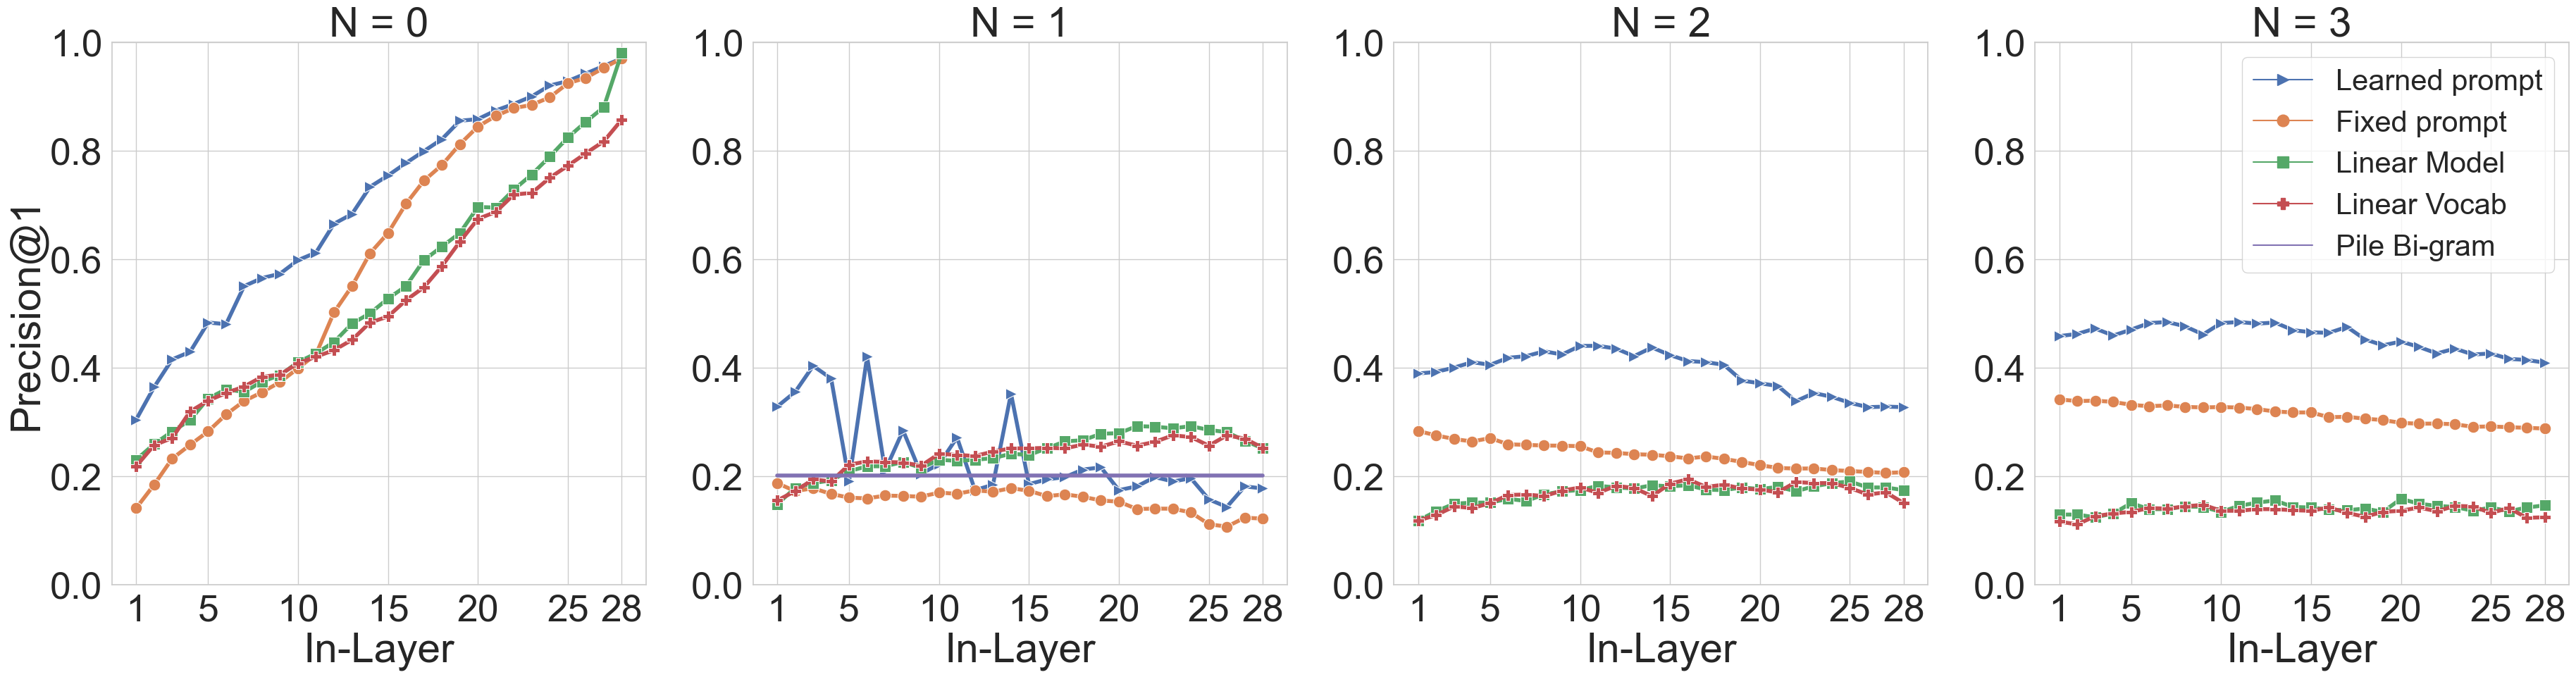

In [112]:
import matplotlib.ticker as ticker
import matplotlib
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams['font.sans-serif'] = "Times New Roman"
fig, axes = plt.subplots(1, 4, figsize=(45, 10))
plot_by_training_objective(prec_df, axes[0], 0, 0, with_legend=False)
axes[1].set_ylabel(' ')
axes[2].set_ylabel(' ')
axes[3].set_ylabel(' ')
# axes[2].get_ylabel().set_visible(False)
# axes[3].get_ylabel().set_visible(False)

# axes[0].xaxis.set_major_locator(ticker.MultipleLocator(3))
# axes[0].yaxis.set_major_locator(ticker.MultipleLocator(0.1))
# axes[1].xaxis.set_major_locator(ticker.MultipleLocator(3))
# axes[1].yaxis.set_major_locator(ticker.MultipleLocator(0.1))
# axes[2].xaxis.set_major_locator(ticker.MultipleLocator(3))
# axes[2].yaxis.set_major_locator(ticker.MultipleLocator(0.1))
# axes[3].xaxis.set_major_locator(ticker.MultipleLocator(3))
# axes[3].yaxis.set_major_locator(ticker.MultipleLocator(0.1))

plot_by_training_objective(prec_df, axes[1], 3, 1, with_legend=False)
plot_by_training_objective(prec_df, axes[2], 3, 2, with_legend=False)
plot_by_training_objective(prec_df, axes[3], 3, 3, with_legend=True)
plt.legend(bbox_to_anchor=(1, 1), fontsize=30, markerscale=2)

plt.savefig("appendix_precision_n=3.pdf", format="pdf", bbox_inches="tight")
#plt.savefig("precision_at_k_1x4.pdf", format="pdf", bbox_inches="tight")

/tmp/ipykernel_31174/1260533130.py:6: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  plot = sns.lineplot(
/tmp/ipykernel_31174/1260533130.py:6: UserWarning: The markers list has more values (5) than needed (4), which may not be intended.
  plot = sns.lineplot(
/tmp/ipykernel_31174/1260533130.py:6: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  plot = sns.lineplot(
/tmp/ipykernel_31174/1260533130.py:6: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  plot = sns.lineplot(
/tmp/ipykernel_31174/1260533130.py:6: UserWarning: The markers list has more values (5) than needed (4), which may not be intended.
  plot = sns.lineplot(
/tmp/ipykernel_31174/1260533130.py:6: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  plot = sns.lineplot(


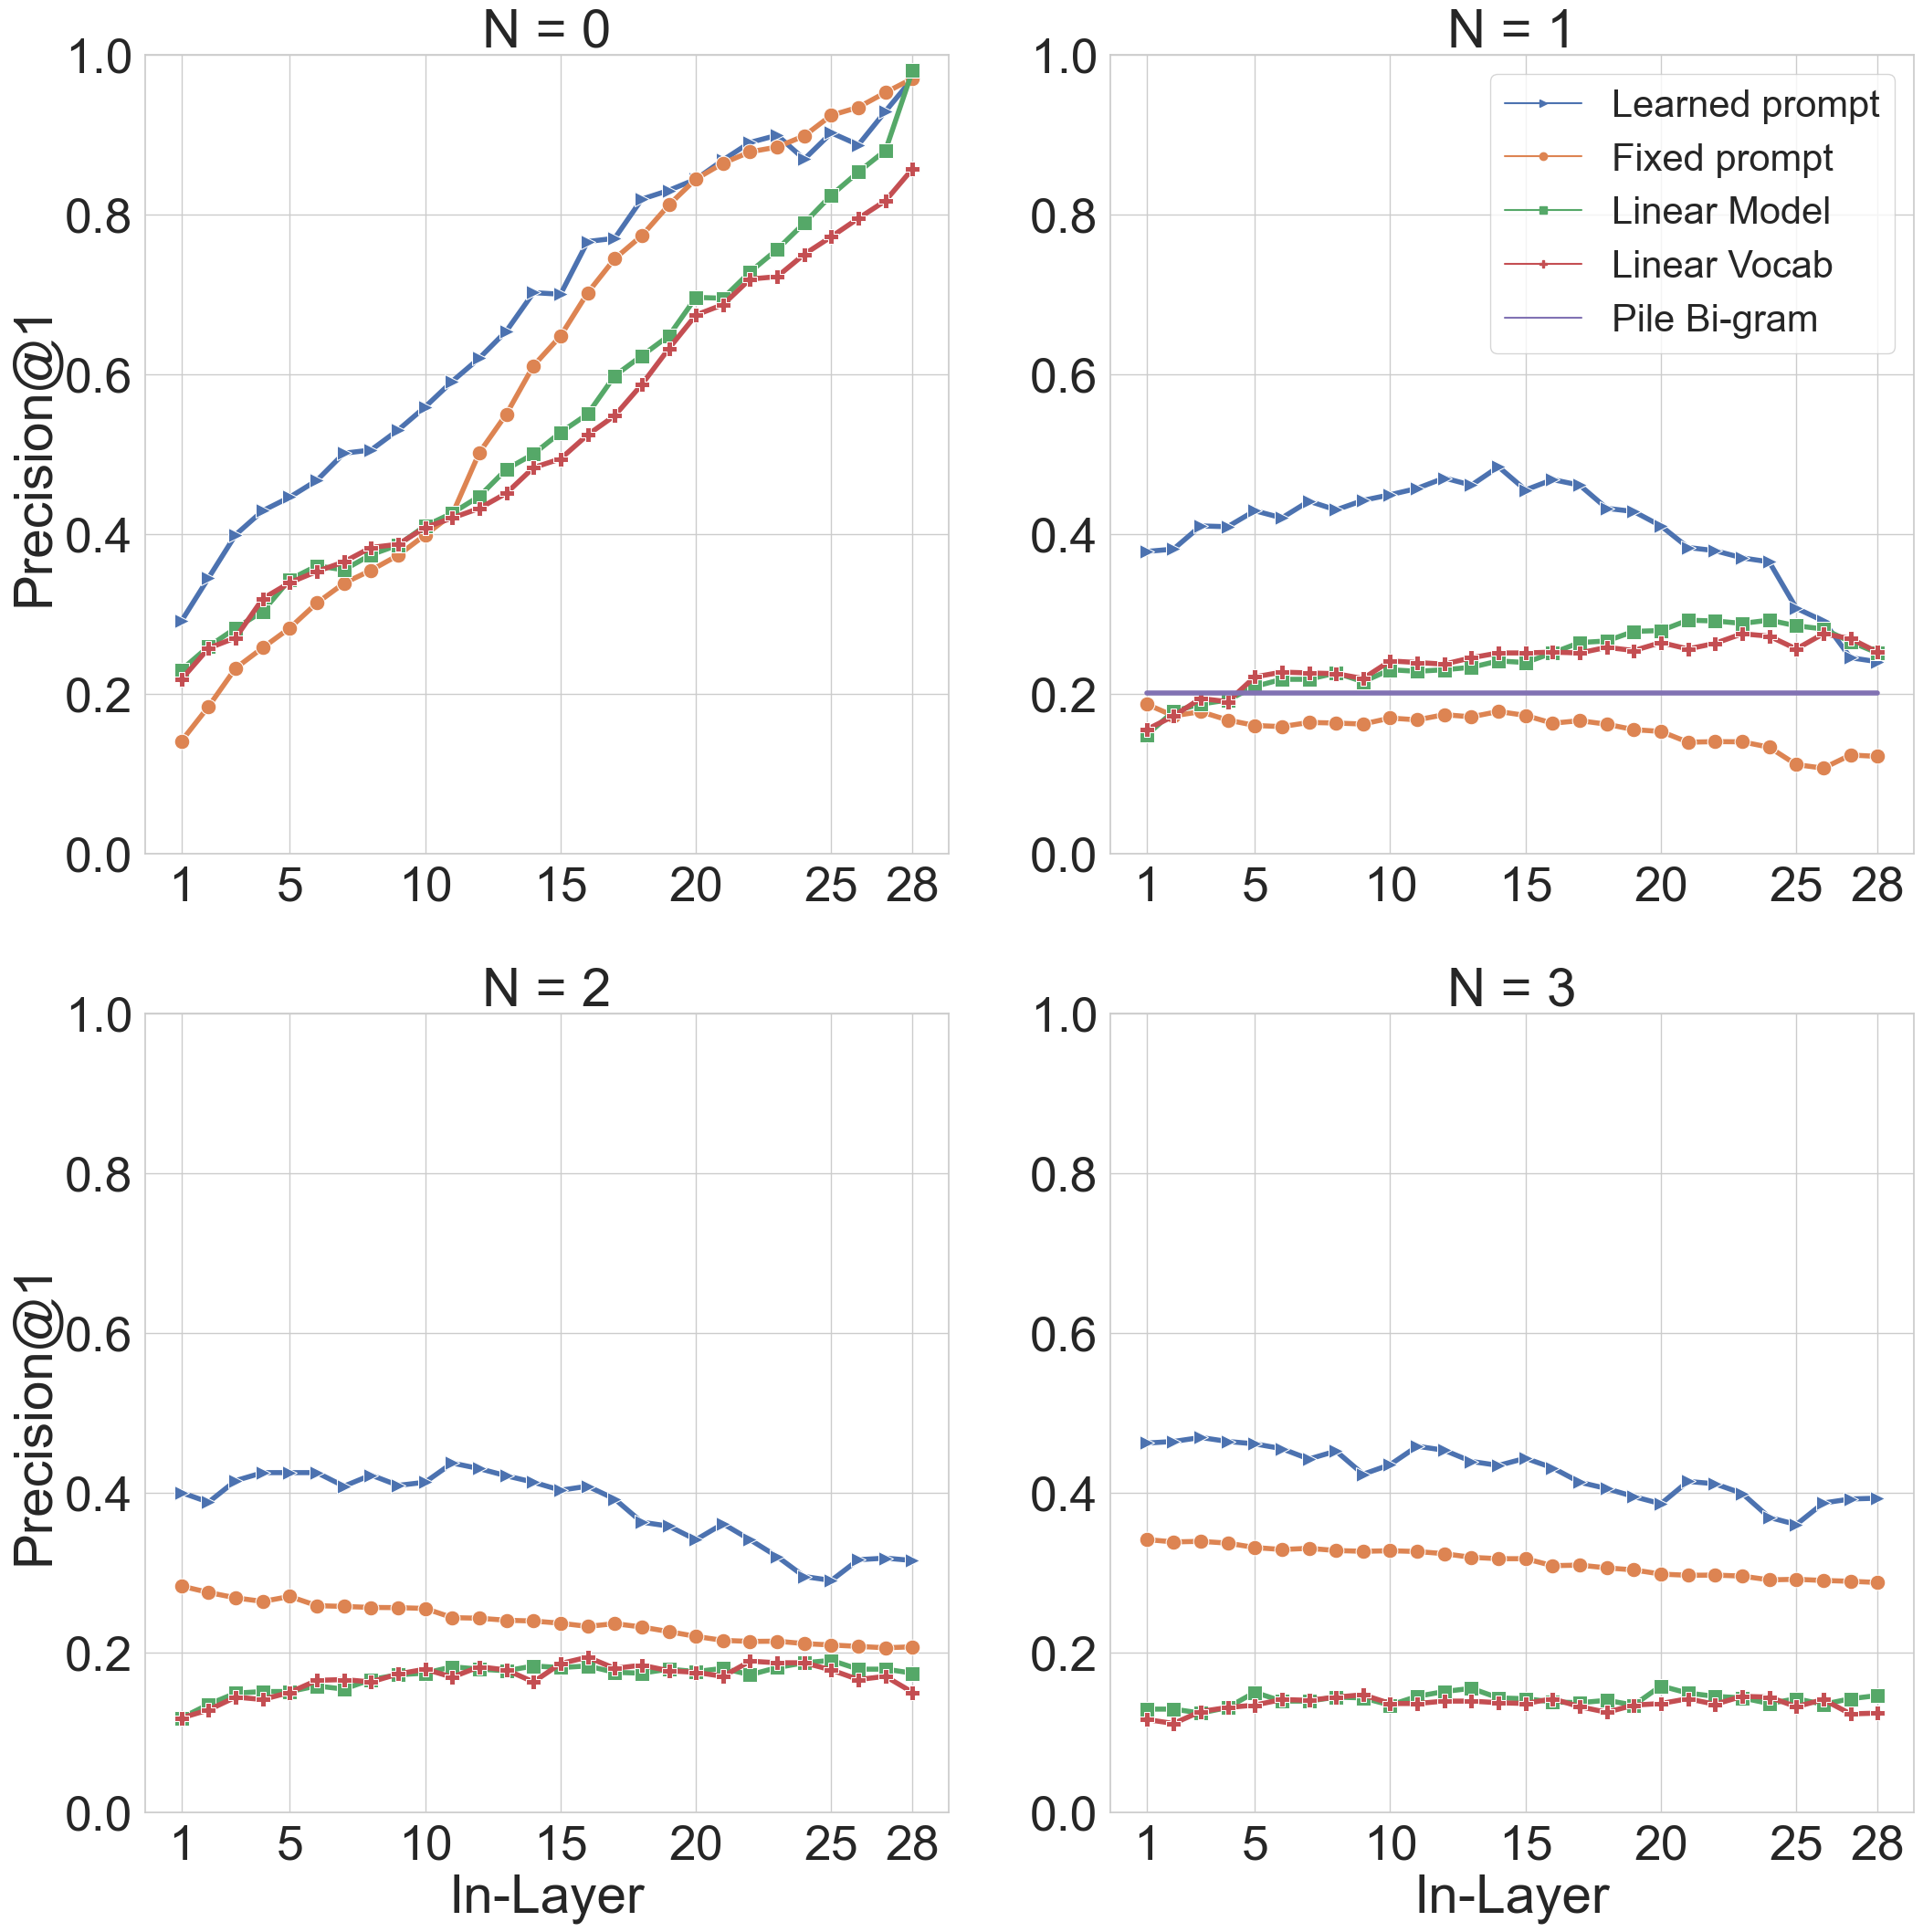

In [106]:
import matplotlib.ticker as ticker
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams['font.sans-serif'] = "Times New Roman"
fig, axes = plt.subplots(2, 2, figsize=(25, 25))
p1 = plot_by_training_objective(prec_df, axes[0][0], 1, 0, with_legend=False)
axes[0][1].set_ylabel(' ')
axes[1][1].set_ylabel(' ')

axes[0][0].set_xlabel(' ')
axes[0][1].set_xlabel(' ')

# axes[0][0].xaxis.set_major_locator(ticker.MultipleLocator(4))
# axes[0][0].yaxis.set_major_locator(ticker.MultipleLocator(0.1))
# axes[1][0].xaxis.set_major_locator(ticker.MultipleLocator(4))
# axes[1][0].yaxis.set_major_locator(ticker.MultipleLocator(0.1))
# axes[0][1].xaxis.set_major_locator(ticker.MultipleLocator(4))
# axes[0][1].yaxis.set_major_locator(ticker.MultipleLocator(0.1))
# axes[1][1].xaxis.set_major_locator(ticker.MultipleLocator(4))
# axes[1][1].yaxis.set_major_locator(ticker.MultipleLocator(0.1))

p2 = plot_by_training_objective(prec_df, axes[0][1], 1, 1, with_legend=True)
p3 = plot_by_training_objective(prec_df, axes[1][0], 1, 2, with_legend=False)
p4 = plot_by_training_objective(prec_df, axes[1][1], 1, 3, with_legend=False)
p2.legend(bbox_to_anchor=(1, 1), fontsize=30, markerscale=2)
#plt.savefig("precision_at_k_2x2.pdf", format="pdf", bbox_inches="tight")

### Surprisal

/tmp/ipykernel_31174/1260533130.py:31: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  plot = sns.lineplot(
/tmp/ipykernel_31174/1260533130.py:31: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  plot = sns.lineplot(
/tmp/ipykernel_31174/1260533130.py:31: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  plot = sns.lineplot(
/tmp/ipykernel_31174/1260533130.py:31: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  plot = sns.lineplot(


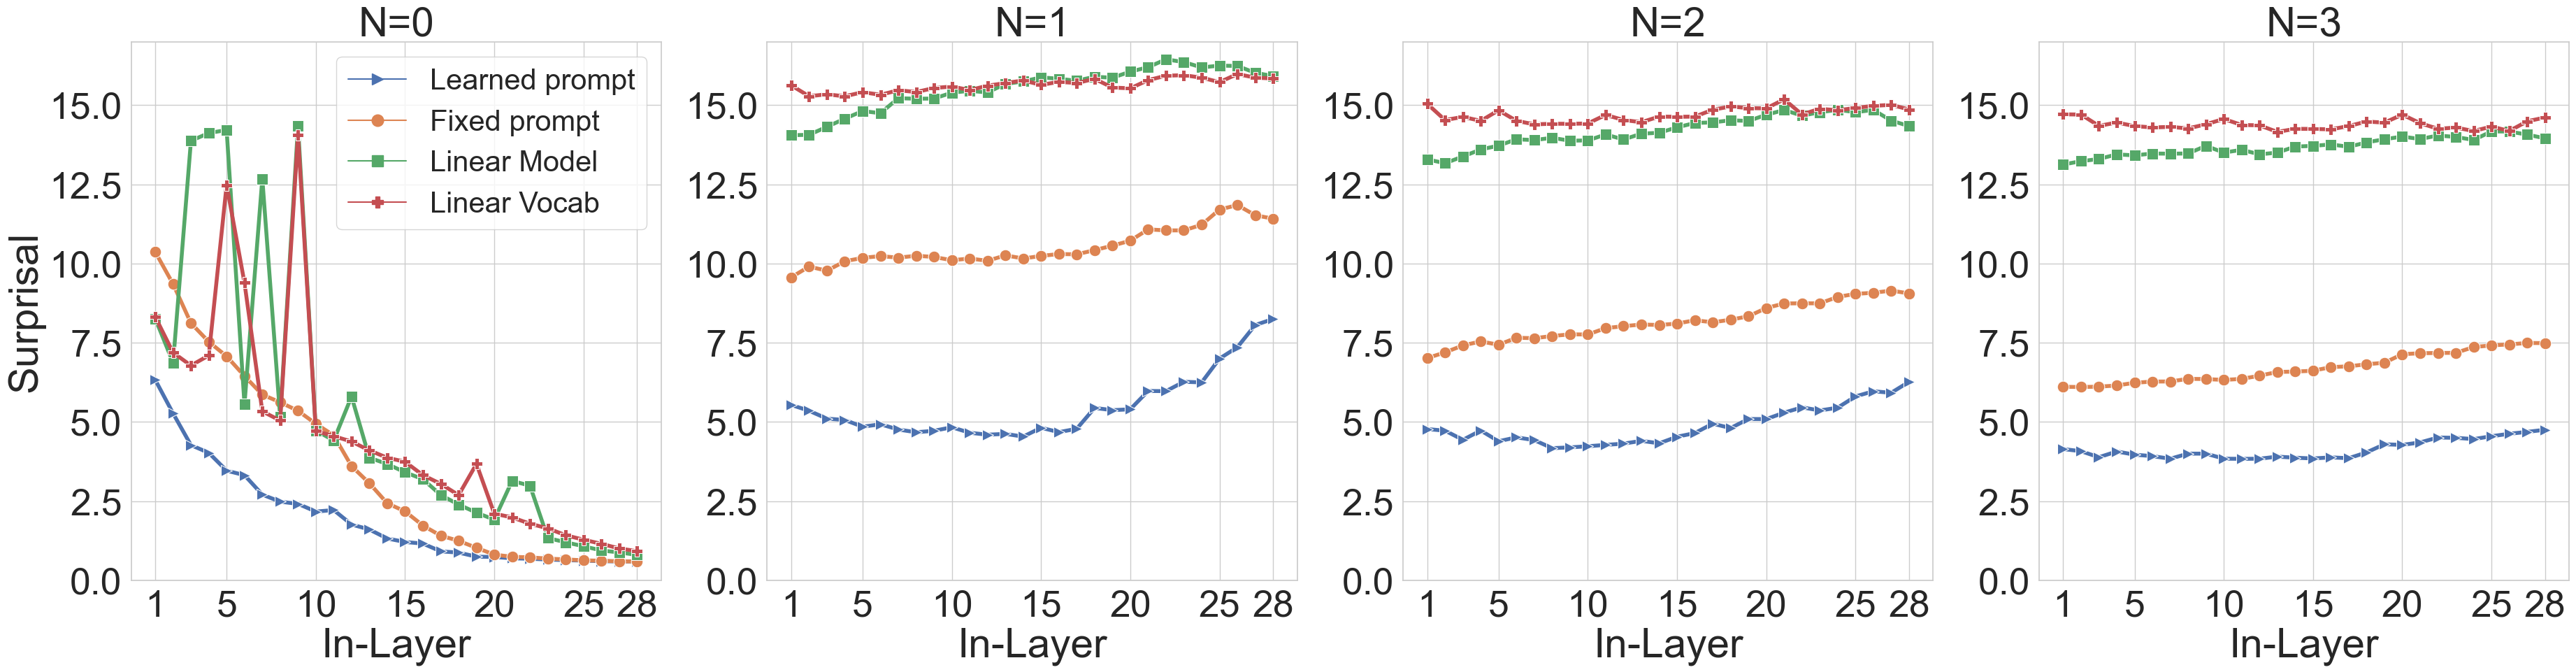

In [108]:
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams['font.sans-serif'] = "Times New Roman"
fig, axes = plt.subplots(1, 4, figsize=(45, 10))
p1 = plot_surprisal(surp_df, axes[0], 0, 0, with_legend=True)
p2 = plot_surprisal(surp_df, axes[1], 1, 1, with_legend=False)
p3 = plot_surprisal(surp_df, axes[2], 2, 2, with_legend=False)
p4 = plot_surprisal(surp_df, axes[3], 3, 3, with_legend=False)
p1.legend(bbox_to_anchor=(1, 1), fontsize=30, markerscale=2)
# p4.legend(bbox_to_anchor=(1, 1), fontsize=30)
axes[1].set_ylabel(' ')
axes[2].set_ylabel(' ')
axes[3].set_ylabel(' ')
plt.savefig("surprisal_1x4_left_legend.pdf", format="pdf", bbox_inches="tight")

/tmp/ipykernel_31174/1062665395.py:31: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  plot = sns.lineplot(
/tmp/ipykernel_31174/1062665395.py:31: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  plot = sns.lineplot(
/tmp/ipykernel_31174/1062665395.py:31: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  plot = sns.lineplot(
/tmp/ipykernel_31174/1062665395.py:31: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  plot = sns.lineplot(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


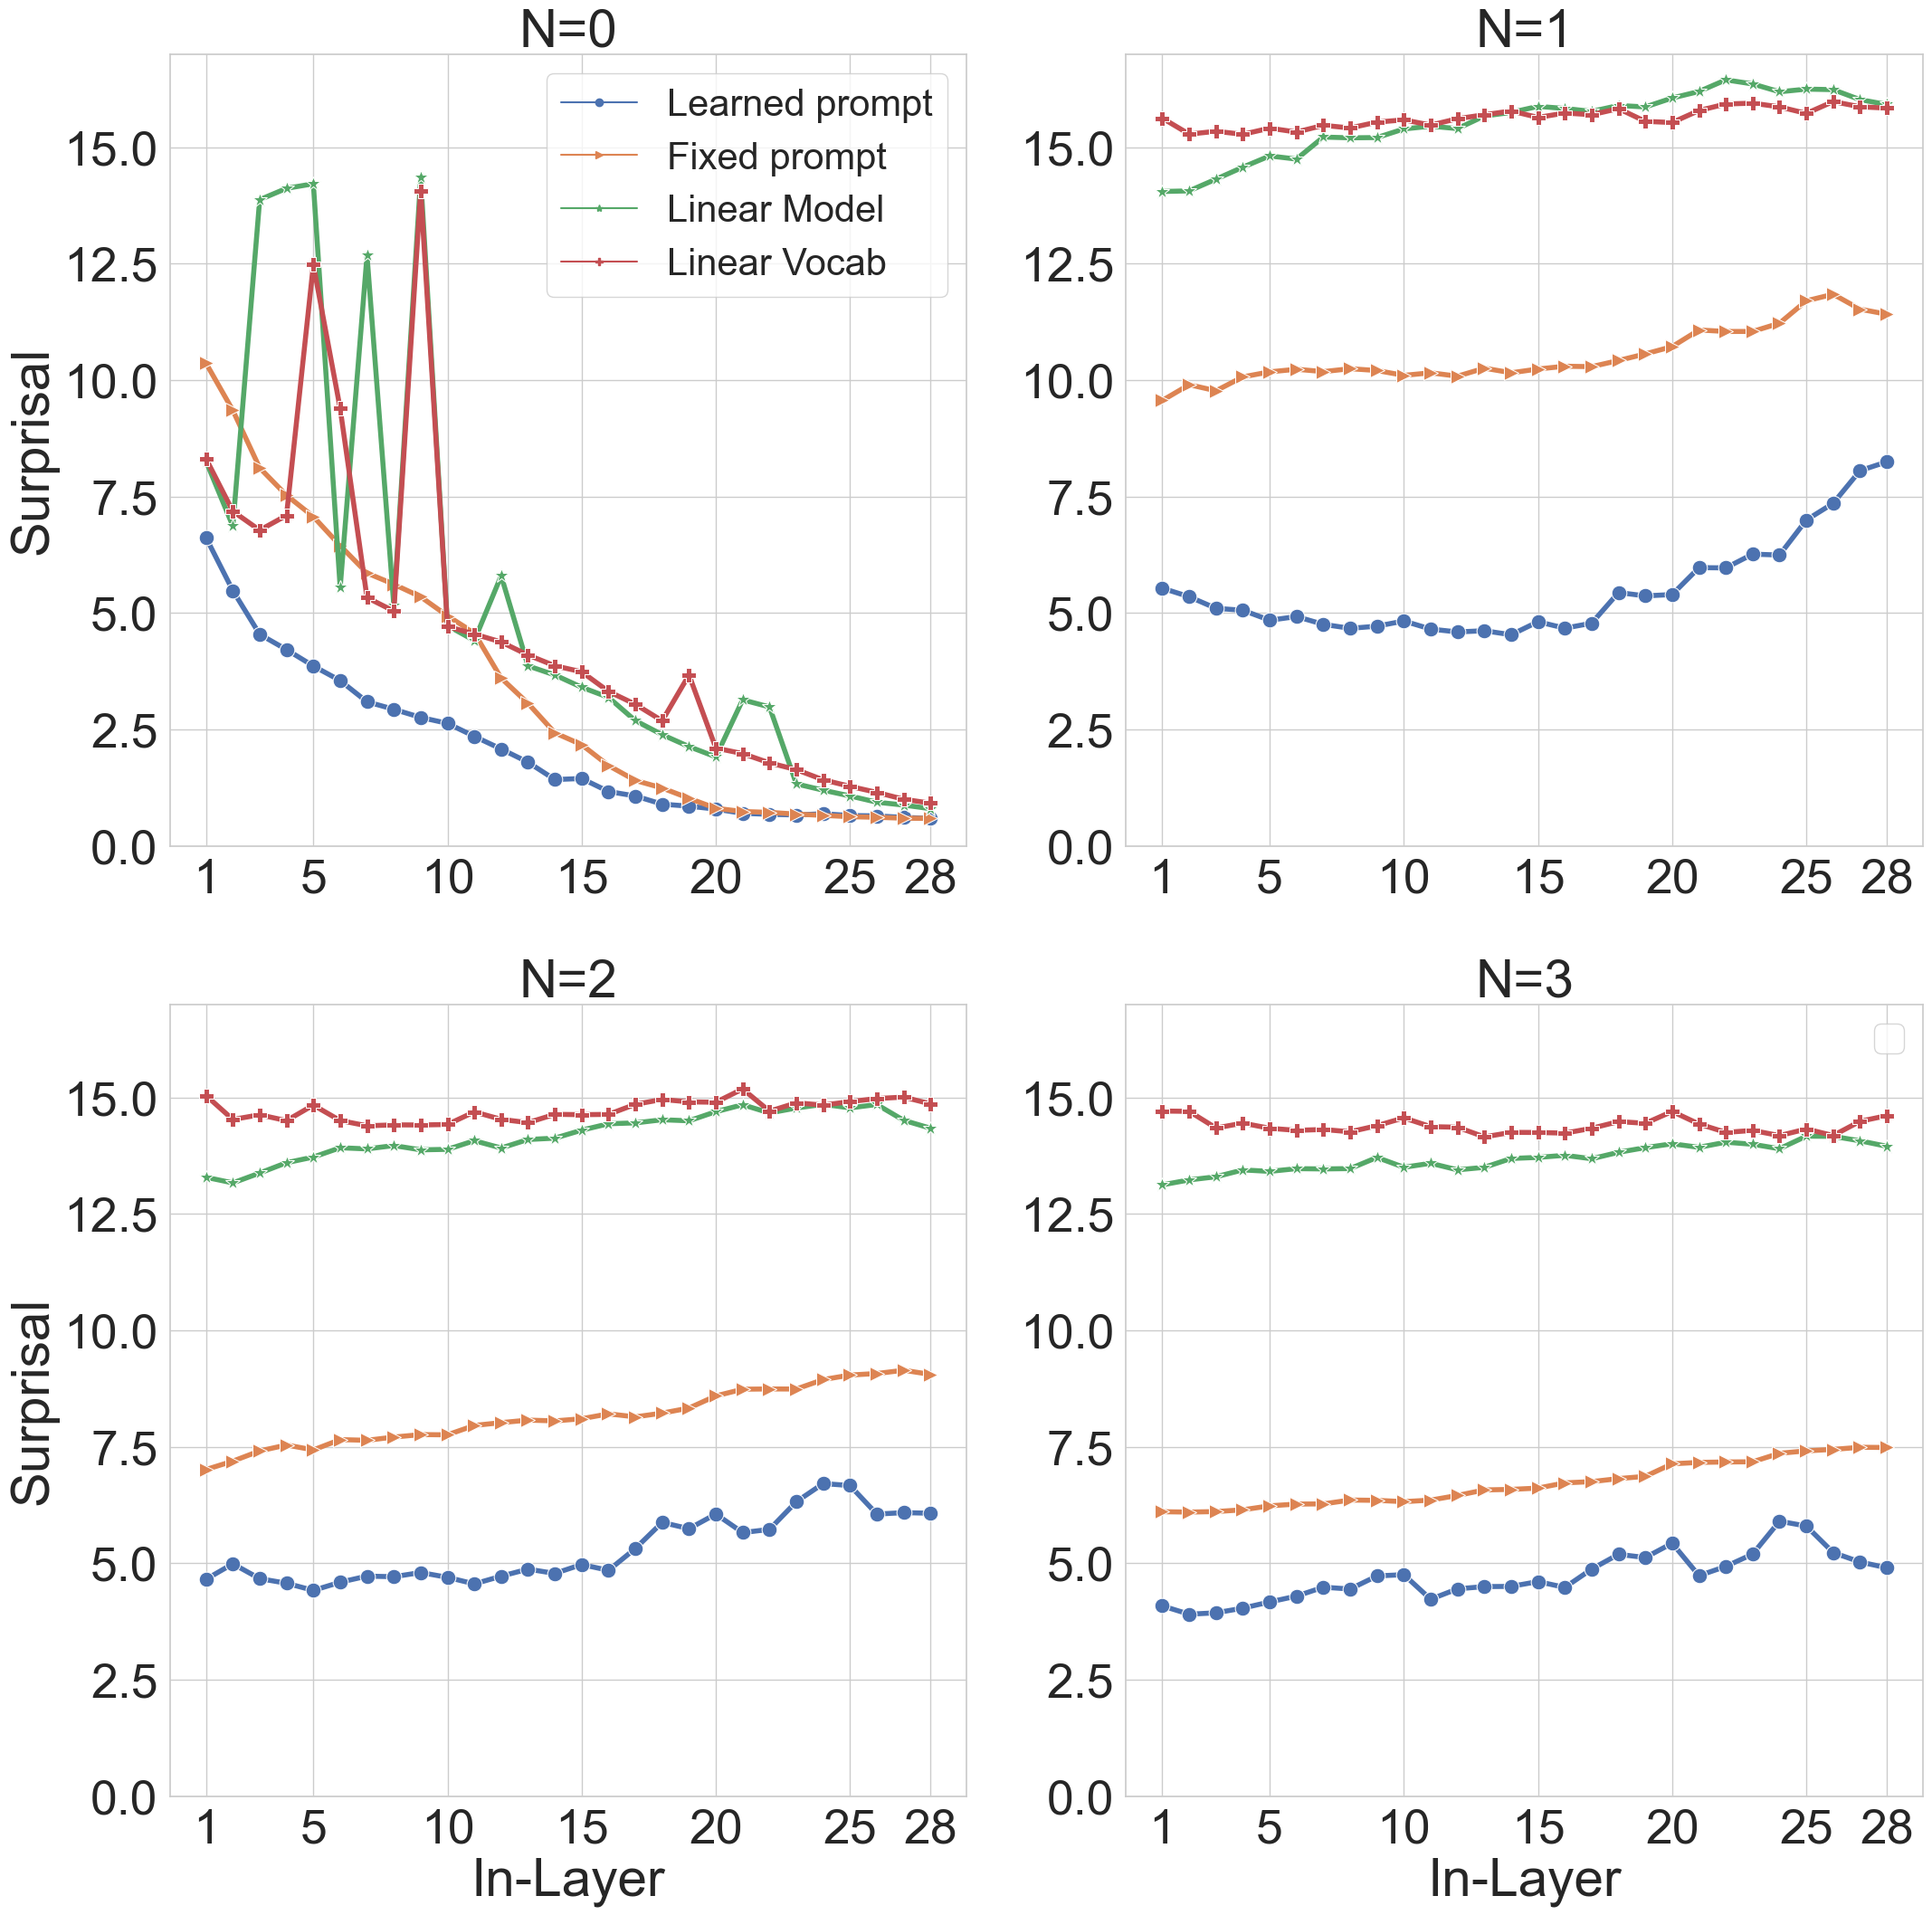

In [48]:
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams['font.sans-serif'] = "Times New Roman"
fig, axes = plt.subplots(2, 2, figsize=(25, 25))
p1 = plot_surprisal(surp_df, axes[0][0], 1, 0, with_legend=True)
p2 = plot_surprisal(surp_df, axes[0][1], 1, 1, with_legend=False)
p3 = plot_surprisal(surp_df, axes[1][0], 1, 2, with_legend=False)
p4 = plot_surprisal(surp_df, axes[1][1], 1, 3, with_legend=False)

axes[0][1].set_ylabel(' ')
axes[1][1].set_ylabel(' ')
axes[0][0].set_xlabel(' ')
axes[0][1].set_xlabel(' ')
p1.legend(bbox_to_anchor=(1, 1), fontsize=30, markerscale=2)
plt.legend(bbox_to_anchor=(1, 1), fontsize=30, markerscale=2)
#plt.savefig("surprisal_at_k_2x2.pdf", format="pdf", bbox_inches="tight")